# Predicting Problematic Internet Use in Children and Adolescents

## Introduction

The goal of this project is to develop a predictive model that analyzes children's physical activity and fitness data to identify early signs of problematic internet use. Specifically, we aim to predict the Severity Impairment Index (sii), a standard measure of problematic internet use, using various physical and behavioral features from the Healthy Brain Network (HBN) dataset.

Identifying patterns of problematic internet use can help trigger interventions to encourage healthier digital habits among children and adolescents.

# Exploratory Data Analysis (EDA)

In this section, we will inspect, visualize, and clean the data to understand the underlying patterns and prepare it for modeling.

## Importing Libraries and Setting Up Environment

In [1]:
# Import necessary libraries
import warnings
from pathlib import Path
from functools import partial

import numpy as np
import pandas as pd
import polars as pl
import polars.selectors as cs
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.utils.data
import lightgbm as lgb
import optuna

from sklearn.metrics import cohen_kappa_score
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder, StandardScaler
from lightgbm import early_stopping, log_evaluation

# Suppress warnings
warnings.filterwarnings("ignore", message="Failed to optimize method")

# Set random seed for reproducibility
SEED = 42
np.random.seed(SEED)

# Can be set to run on small data subset to validate code works
IS_TEST = False

# Loading the Data

In [2]:
# Define data directory
DATA_DIR = Path("data")

# Load train and test datasets
train = pl.read_csv(DATA_DIR / "train.csv")
test = pl.read_csv(DATA_DIR / "test.csv")

# Understanding the Data Structure

The datasets contain various measurements from multiple instruments, including demographics, physical measures, fitness assessments, and questionnaires. The target variable is the Severity Impairment Index (sii), which is derived from the Parent-Child Internet Addiction Test (PCIAT).

## Checking for Missing Values

In [3]:
# Check for missing values in the training data
missing_values = train.select([pl.col(c).is_null().sum().alias(f"null_count_{c}") for c in train.columns])

# Use unpivot without the 'columns' keyword
# The first argument is the columns to unpivot, and the second argument is their values
missing_values_unpivoted = missing_values.unpivot(missing_values.columns).sort('value', descending=True)

# Display the missing values sorted by count
print(missing_values_unpivoted)

shape: (82, 2)
┌─────────────────────────────────┬───────┐
│ variable                        ┆ value │
│ ---                             ┆ ---   │
│ str                             ┆ u32   │
╞═════════════════════════════════╪═══════╡
│ null_count_PAQ_A-Season         ┆ 3485  │
│ null_count_PAQ_A-PAQ_A_Total    ┆ 3485  │
│ null_count_Fitness_Endurance-T… ┆ 3220  │
│ null_count_Fitness_Endurance-T… ┆ 3220  │
│ null_count_Fitness_Endurance-M… ┆ 3217  │
│ …                               ┆ …     │
│ null_count_PreInt_EduHx-Season  ┆ 420   │
│ null_count_id                   ┆ 0     │
│ null_count_Basic_Demos-Enroll_… ┆ 0     │
│ null_count_Basic_Demos-Age      ┆ 0     │
│ null_count_Basic_Demos-Sex      ┆ 0     │
└─────────────────────────────────┴───────┘


We observe that many features have missing values, which need to be addressed during data preprocessing.

# Describing the Factors (Features)

In [4]:
# List of target columns
TARGET_COLS = [
    "PCIAT-PCIAT_01", "PCIAT-PCIAT_02", "PCIAT-PCIAT_03", "PCIAT-PCIAT_04", "PCIAT-PCIAT_05",
    "PCIAT-PCIAT_06", "PCIAT-PCIAT_07", "PCIAT-PCIAT_08", "PCIAT-PCIAT_09", "PCIAT-PCIAT_10",
    "PCIAT-PCIAT_11", "PCIAT-PCIAT_12", "PCIAT-PCIAT_13", "PCIAT-PCIAT_14", "PCIAT-PCIAT_15",
    "PCIAT-PCIAT_16", "PCIAT-PCIAT_17", "PCIAT-PCIAT_18", "PCIAT-PCIAT_19", "PCIAT-PCIAT_20",
    "PCIAT-PCIAT_Total", "sii",
]

# List of feature columns
FEATURE_COLS = [
    "Basic_Demos-Enroll_Season", "Basic_Demos-Age", "Basic_Demos-Sex", "CGAS-Season",
    "CGAS-CGAS_Score", "Physical-Season", "Physical-BMI", "Physical-Height", "Physical-Weight",
    "Physical-Waist_Circumference", "Physical-Diastolic_BP", "Physical-HeartRate",
    "Physical-Systolic_BP", "Fitness_Endurance-Season", "Fitness_Endurance-Max_Stage",
    "Fitness_Endurance-Time_Mins", "Fitness_Endurance-Time_Sec", "FGC-Season", "FGC-FGC_CU",
    "FGC-FGC_CU_Zone", "FGC-FGC_GSND", "FGC-FGC_GSND_Zone", "FGC-FGC_GSD", "FGC-FGC_GSD_Zone",
    "FGC-FGC_PU", "FGC-FGC_PU_Zone", "FGC-FGC_SRL", "FGC-FGC_SRL_Zone", "FGC-FGC_SRR",
    "FGC-FGC_SRR_Zone", "FGC-FGC_TL", "FGC-FGC_TL_Zone", "BIA-Season", "BIA-BIA_Activity_Level_num",
    "BIA-BIA_BMC", "BIA-BIA_BMI", "BIA-BIA_BMR", "BIA-BIA_DEE", "BIA-BIA_ECW", "BIA-BIA_FFM",
    "BIA-BIA_FFMI", "BIA-BIA_FMI", "BIA-BIA_Fat", "BIA-BIA_Frame_num", "BIA-BIA_ICW", "BIA-BIA_LDM",
    "BIA-BIA_LST", "BIA-BIA_SMM", "BIA-BIA_TBW", "PAQ_A-Season", "PAQ_A-PAQ_A_Total",
    "PAQ_C-Season", "PAQ_C-PAQ_C_Total", "SDS-Season", "SDS-SDS_Total_Raw", "SDS-SDS_Total_T",
    "PreInt_EduHx-Season", "PreInt_EduHx-computerinternet_hoursday",
]

These features encompass demographic information, physical measures, fitness assessments, bio-electric impedance analysis, physical activity questionnaires, sleep disturbance scales, and internet usage.

# Visualizing Target Variable Distribution

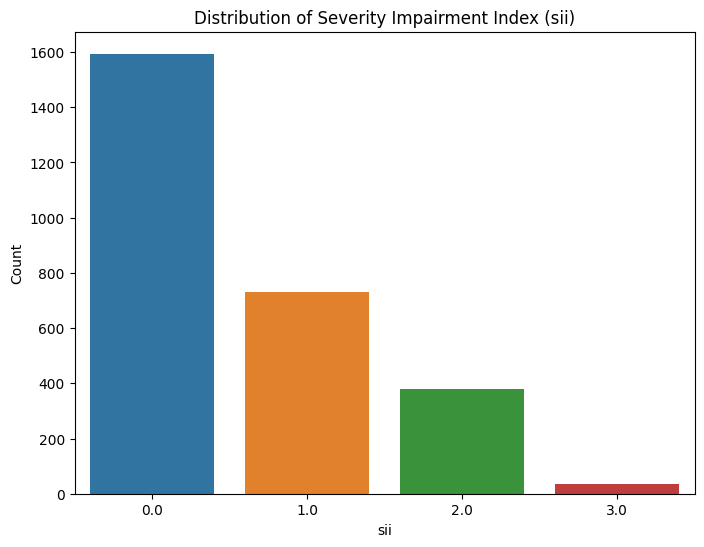

In [5]:
# Convert to pandas for visualization
train_pd = train.select(TARGET_COLS).to_pandas()

# Plot the distribution of 'sii'
plt.figure(figsize=(8, 6))
sns.countplot(x='sii', data=train_pd)
plt.title('Distribution of Severity Impairment Index (sii)')
plt.xlabel('sii')
plt.ylabel('Count')
plt.show()

We observe that the target variable 'sii' is imbalanced, with most participants having lower severity levels.

# Correlation Analysis

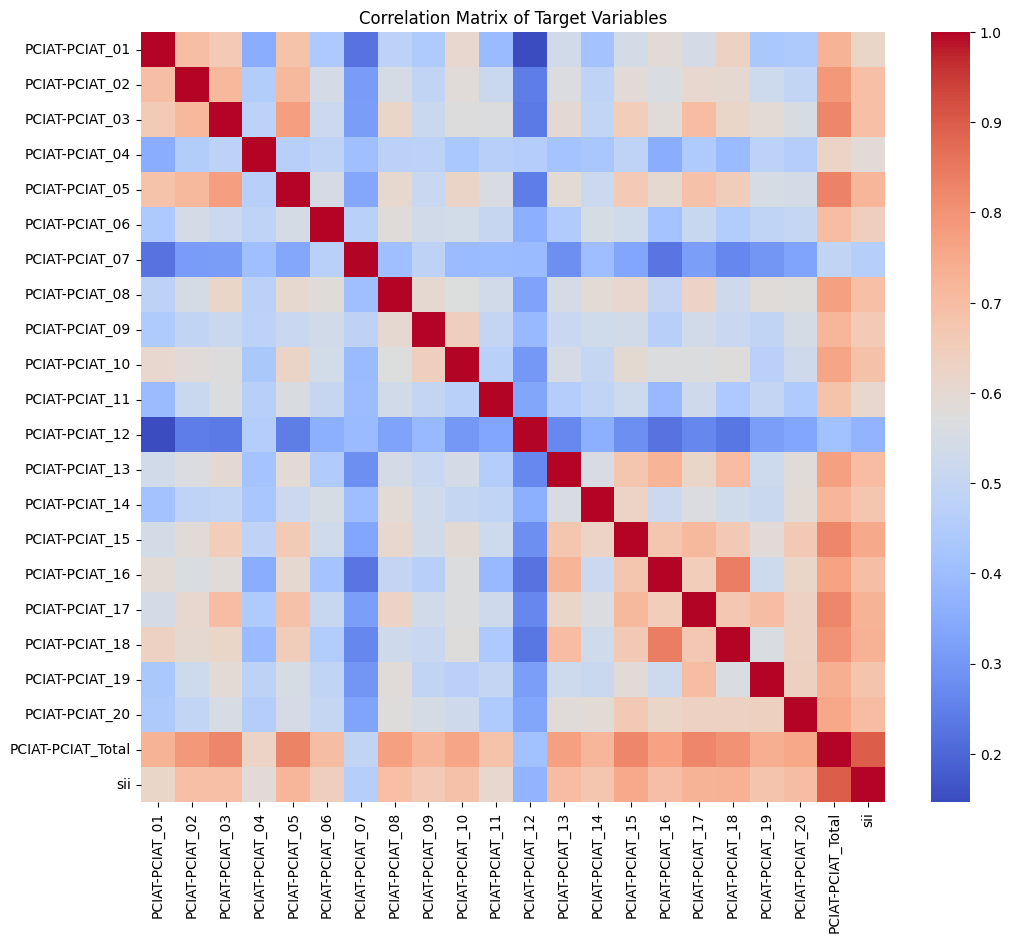

In [6]:
# Compute correlation matrix
corr_matrix = train_pd.corr()

# Plot the heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm')
plt.title('Correlation Matrix of Target Variables')
plt.show()

Due to the high number of target variables, the heatmap is dense. We focus on the correlations between 'PCIAT-PCIAT_Total' and 'sii'.

# Handling Missing Data

Given the presence of missing values, we need to decide how to handle them.

* Numeric Features: We'll fill missing values with the mean of each feature.
* Categorical Features: We'll fill missing values with a special category 'NAN'.

# Data Preprocessing

## Concatenating Train and Test Data

In [7]:
with pl.StringCache():
    train_test = pl.concat([train, test], how="diagonal")
    train_test = train_test.with_columns(cs.string().cast(pl.Categorical).fill_null("NAN"))

# Split back into train and test
train = train_test[: train.height]
test = train_test[train.height:]

## Dropping Rows with Missing Target Values

In [8]:
# Drop rows where target variables are missing
train_without_null = train.drop_nulls(subset=TARGET_COLS)

## Separating Features and Target Variables

In [9]:
# Select features and target variables
X = train_without_null.select(FEATURE_COLS)
X_test = test.select(FEATURE_COLS)
y = train_without_null.select(TARGET_COLS)

## Converting to Pandas DataFrames

In [10]:
# Convert to pandas for compatibility with scikit-learn and PyTorch
X = X.to_pandas()
X_test = X_test.to_pandas()
y = y.to_pandas()

## Handling Missing Values

In [11]:
# Identify numerical features
num_features = X.select_dtypes(include=[np.number]).columns.tolist()

# Fill missing numerical values with mean
X[num_features] = X[num_features].fillna(X[num_features].mean())
X_test[num_features] = X_test[num_features].fillna(X_test[num_features].mean())

## Encoding Categorical Features

In [12]:
# Identify categorical features
cat_features = [col for col in FEATURE_COLS if col not in num_features]

# Fill missing categorical values and encode
label_encoders = {}
for col in cat_features:
    X[col] = X[col].astype("category")
    X_test[col] = X_test[col].astype("category")

    # Add 'NAN' category if not present
    if "NAN" not in X[col].cat.categories:
        X[col] = X[col].cat.add_categories("NAN")
    if "NAN" not in X_test[col].cat.categories:
        X_test[col] = X_test[col].cat.add_categories("NAN")

    X[col] = X[col].fillna("NAN")
    X_test[col] = X_test[col].fillna("NAN")

    # Label encoding
    le = LabelEncoder()
    le.fit(pd.concat([X[col], X_test[col]], axis=0).astype(str))
    X[col] = le.transform(X[col].astype(str))
    X_test[col] = le.transform(X_test[col].astype(str))
    label_encoders[col] = le

## Feature Scaling

In [13]:
# Standardize numerical features
scaler = StandardScaler()
scaler.fit(pd.concat([X[num_features], X_test[num_features]], axis=0))
X[num_features] = scaler.transform(X[num_features])
X_test[num_features] = scaler.transform(X_test[num_features])

## Converting to NumPy Arrays

In [14]:
# Convert to NumPy arrays
X_np = X.values
X_test_np = X_test.values
y_np = y.values

# Modeling

We will use a combination of a neural network and a LightGBM model to predict the target variable 'sii'. By combining both models, we aim to leverage the strengths of each and improve overall performance.

## Neural Network Model

### Defining the Dataset Class

In [15]:
class TabularDataset(torch.utils.data.Dataset):
    """
    Dataset for handling tabular data, separating categorical and numerical features.
    """

    def __init__(self, X_categorical, X_numerical, y=None):
        self.X_categorical = torch.tensor(X_categorical, dtype=torch.long)
        self.X_numerical = torch.tensor(X_numerical, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32) if y is not None else None

    def __len__(self):
        return len(self.X_categorical)

    def __getitem__(self, idx):
        if self.y is not None:
            return self.X_categorical[idx], self.X_numerical[idx], self.y[idx]
        else:
            return self.X_categorical[idx], self.X_numerical[idx]

### Defining the Neural Network Architecture

In [16]:
class MultiTargetRegressionModel(nn.Module):
    """
    Neural network model for multi-target regression using embeddings for categorical features
    and fully connected layers for regression.
    """

    def __init__(self, embedding_sizes, num_numerical_features, output_size):
        super(MultiTargetRegressionModel, self).__init__()
        self.embeddings = nn.ModuleList(
            [nn.Embedding(num_embeddings=categories, embedding_dim=size) for categories, size in embedding_sizes]
        )
        self.embedding_output_size = sum([size for _, size in embedding_sizes])
        self.fc1 = nn.Linear(self.embedding_output_size + num_numerical_features, 128)
        self.fc2 = nn.Linear(128, 64)
        self.output = nn.Linear(64, output_size)
        self.dropout = nn.Dropout(0.1)
        self.relu = nn.ReLU()

    def forward(self, x_categorical, x_numerical):
        x = [emb(x_categorical[:, i]) for i, emb in enumerate(self.embeddings)]
        x = torch.cat(x, 1)
        x = torch.cat([x, x_numerical], 1)
        x = self.dropout(self.relu(self.fc1(x)))
        x = self.dropout(self.relu(self.fc2(x)))
        x = self.output(x)
        return x


## Model Explanation:

* Embeddings for Categorical Features: We use embedding layers to represent categorical features in a dense vector space.
* Fully Connected Layers: After combining embeddings with numerical features, we pass them through fully connected layers.
* Output Layer: # Prepare embeddings
embedding_sizes = []
for col in cat_features:
    num_categories = len(label_encoders[col].classes_)
    embedding_size = min(50, (num_categories + 1) // 2)
    embedding_sizes.append((num_categories, embedding_size))

num_numerical_features = len(num_features)
output_size = len(TARGET_COLS)
The model outputs predictions for all target variables.

## Preparing the Data for the Neural Network

In [17]:
# Prepare embeddings
embedding_sizes = []
for col in cat_features:
    num_categories = len(label_encoders[col].classes_)
    embedding_size = min(50, (num_categories + 1) // 2)
    embedding_sizes.append((num_categories, embedding_size))

num_numerical_features = len(num_features)
output_size = len(TARGET_COLS)

## Splitting the Data for Cross-Validation

In [18]:
# Define target variables for stratification
y_sii = y["sii"].to_numpy()
y_total = y["PCIAT-PCIAT_Total"].to_numpy()

# Stratified K-Fold Cross-Validation
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)
models = []
y_pred = np.full((X.shape[0], len(TARGET_COLS)), fill_value=np.nan)

## Training the Neural Network

In [19]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

for fold, (train_idx, val_idx) in enumerate(skf.split(X, y_sii)):
    print(f"Fold {fold + 1}")
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

    # Prepare data
    X_train_categorical = X_train[cat_features].values.astype(np.int64)
    X_val_categorical = X_val[cat_features].values.astype(np.int64)
    X_train_numerical = X_train[num_features].values.astype(np.float32)
    X_val_numerical = X_val[num_features].values.astype(np.float32)

    y_train_values = y_train.values.astype(np.float32)
    y_val_values = y_val.values.astype(np.float32)

    train_dataset = TabularDataset(X_train_categorical, X_train_numerical, y_train_values)
    val_dataset = TabularDataset(X_val_categorical, X_val_numerical, y_val_values)

    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=256, shuffle=True)
    val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=256, shuffle=False)

    # Initialize model
    model = MultiTargetRegressionModel(embedding_sizes, num_numerical_features, output_size)
    model = model.to(device)

    # Define loss and optimizer
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    num_epochs = 1 if IS_TEST else 100
    best_val_loss = np.inf
    patience = 10
    counter = 0
    best_model_state = None

    # Training loop
    for epoch in range(num_epochs):
        model.train()
        train_losses = []
        for X_cat_batch, X_num_batch, y_batch in train_loader:
            X_cat_batch = X_cat_batch.to(device)
            X_num_batch = X_num_batch.to(device)
            y_batch = y_batch.to(device)

            optimizer.zero_grad()
            outputs = model(X_cat_batch, X_num_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
            train_losses.append(loss.item())

        # Validation
        model.eval()
        val_losses = []
        with torch.no_grad():
            for X_cat_batch, X_num_batch, y_batch in val_loader:
                X_cat_batch = X_cat_batch.to(device)
                X_num_batch = X_num_batch.to(device)
                y_batch = y_batch.to(device)

                outputs = model(X_cat_batch, X_num_batch)
                loss = criterion(outputs, y_batch)
                val_losses.append(loss.item())

        train_loss = np.mean(train_losses)
        val_loss = np.mean(val_losses)

        print(f"Epoch {epoch + 1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

        # Early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_state = model.state_dict()
            counter = 0
        else:
            counter += 1
            if counter >= patience:
                print("Early stopping")
                break

    if best_model_state is None:
        print("No valid model was trained in this fold due to NaNs.")
        continue

    model.load_state_dict(best_model_state)
    models.append(model)

    # Predictions on validation set
    model.eval()
    val_preds = []
    with torch.no_grad():
        for X_cat_batch, X_num_batch, y_batch in val_loader:
            X_cat_batch = X_cat_batch.to(device)
            X_num_batch = X_num_batch.to(device)
            outputs = model(X_cat_batch, X_num_batch)
            val_preds.append(outputs.cpu().numpy())
    val_preds = np.vstack(val_preds)

    y_pred[val_idx] = val_preds

Fold 1
Epoch 1/100, Train Loss: 55.6511, Val Loss: 51.3506
Epoch 2/100, Train Loss: 52.6686, Val Loss: 47.1105
Epoch 3/100, Train Loss: 47.3656, Val Loss: 40.3941
Epoch 4/100, Train Loss: 39.6737, Val Loss: 31.8910
Epoch 5/100, Train Loss: 29.5584, Val Loss: 22.1352
Epoch 6/100, Train Loss: 20.7115, Val Loss: 16.9550
Epoch 7/100, Train Loss: 17.9763, Val Loss: 16.9521
Epoch 8/100, Train Loss: 17.2828, Val Loss: 16.0264
Epoch 9/100, Train Loss: 16.4365, Val Loss: 15.9805
Epoch 10/100, Train Loss: 16.2498, Val Loss: 15.7547
Epoch 11/100, Train Loss: 16.1956, Val Loss: 15.5650
Epoch 12/100, Train Loss: 15.9764, Val Loss: 15.4448
Epoch 13/100, Train Loss: 15.5614, Val Loss: 15.3403
Epoch 14/100, Train Loss: 15.6915, Val Loss: 15.3212
Epoch 15/100, Train Loss: 15.4532, Val Loss: 15.2706
Epoch 16/100, Train Loss: 15.0078, Val Loss: 15.1908
Epoch 17/100, Train Loss: 14.8204, Val Loss: 15.2107
Epoch 18/100, Train Loss: 15.0247, Val Loss: 15.1694
Epoch 19/100, Train Loss: 14.6992, Val Loss: 15.

## Training Process Explanation:

* We perform 5-fold cross-validation to evaluate the model's performance.
* Early stopping is used to prevent overfitting.
* The model predicts all target variables simultaneously.

## LightGBM Model

We also train a LightGBM model to predict 'PCIAT-PCIAT_Total'.

### Defining LightGBM Parameters

In [20]:
lgb_params = {
    'objective': 'regression',
    'metric': 'rmse',
    'verbosity': -1,
    'boosting_type': 'gbdt',
    'n_jobs': -1,
    'seed': SEED,
}

## Training the LightGBM Model

In [21]:
categorical_feature_indices = [X.columns.get_loc(col) for col in cat_features]

models_lgb = []
y_pred_lgb = np.full((X.shape[0],), fill_value=np.nan)

for fold, (train_idx, val_idx) in enumerate(skf.split(X, y_sii)):
    print(f"LightGBM Fold {fold + 1}")
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y_total[train_idx], y_total[val_idx]

    train_data = lgb.Dataset(X_train, label=y_train, categorical_feature=categorical_feature_indices)
    val_data = lgb.Dataset(X_val, label=y_val, categorical_feature=categorical_feature_indices)

    model = lgb.train(
        params=lgb_params,
        train_set=train_data,
        num_boost_round=1000,
        valid_sets=[train_data, val_data],
        callbacks=[early_stopping(stopping_rounds=50), log_evaluation(100)],
    )
    models_lgb.append(model)
    y_pred_lgb[val_idx] = model.predict(X_val, num_iteration=model.best_iteration)

LightGBM Fold 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[34]	training's rmse: 12.3756	valid_1's rmse: 17.5933
LightGBM Fold 2
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[25]	training's rmse: 13.7843	valid_1's rmse: 16.9011
LightGBM Fold 3
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[29]	training's rmse: 13.15	valid_1's rmse: 16.9913
LightGBM Fold 4
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[22]	training's rmse: 13.9273	valid_1's rmse: 17.2618
LightGBM Fold 5
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[22]	training's rmse: 13.8964	valid_1's rmse: 17.4171


## Training Process Explanation:

* We perform 5-fold cross-validation.
* Early stopping is used based on validation loss.
* Categorical features are specified for LightGBM to handle them internally.

## Model Evaluation and Optimization

### Combining Neural Network and LightGBM Predictions

We aim to combine the predictions from both models to improve performance.

### Defining an Optimizer for Thresholds

In [22]:
class OptimizedRounder:
    """
    Optimizes rounding of continuous predictions into discrete class labels by maximizing
    the Quadratic Weighted Kappa (QWK) score using Optuna optimization.
    """

    def __init__(self, n_classes: int, n_trials: int = 100):
        self.n_classes = n_classes
        self.labels = np.arange(n_classes)
        self.n_trials = n_trials
        self.metric = partial(cohen_kappa_score, weights="quadratic")

    def fit(self, y_pred: np.ndarray, y_true: np.ndarray) -> None:
        y_pred = self._normalize(y_pred)

        def objective(trial: optuna.Trial) -> float:
            thresholds = []
            for i in range(self.n_classes - 1):
                low = thresholds[-1] if i > 0 else y_pred.min()
                high = y_pred.max()
                th = trial.suggest_float(f"threshold_{i}", low, high)
                thresholds.append(th)
            try:
                y_pred_rounded = np.digitize(y_pred, thresholds)
            except ValueError:
                return -100
            return self.metric(y_true, y_pred_rounded)

        optuna.logging.disable_default_handler()
        study = optuna.create_study(direction="maximize")

        with np.errstate(invalid='ignore'):
            study.optimize(objective, n_trials=self.n_trials)

        self.thresholds = [study.best_params[f"threshold_{i}"] for i in range(self.n_classes - 1)]

    def predict(self, y_pred: np.ndarray) -> np.ndarray:
        assert hasattr(self, "thresholds"), "You must call fit() before predict()"
        y_pred = self._normalize(y_pred)
        return np.digitize(y_pred, self.thresholds)

    def _normalize(self, y: np.ndarray) -> np.ndarray:
        return (y - y.min()) / (y.max() - y.min()) * (self.n_classes - 1)

## Optimizing the Weights for Combining Models

In [23]:
def optimize_weights(y_true, y_pred_nn, y_pred_lgb):
    def objective(trial):
        w_nn = trial.suggest_float('w_nn', 0.0, 1.0)
        y_pred_combined = w_nn * y_pred_nn + (1 - w_nn) * y_pred_lgb
        optimizer_rounder = OptimizedRounder(n_classes=4, n_trials=100)
        optimizer_rounder.fit(y_pred_combined, y_true)
        y_pred_rounded = optimizer_rounder.predict(y_pred_combined)
        qwk = cohen_kappa_score(y_true, y_pred_rounded, weights="quadratic")
        return qwk

    study = optuna.create_study(direction='maximize')
    study.optimize(objective, n_trials=50)
    best_weight = study.best_params['w_nn']
    best_qwk = study.best_value
    print(f"Best weight: {best_weight}, Best QWK: {best_qwk}")
    return best_weight

# Combine predictions
y_pred_total = y_pred[:, TARGET_COLS.index("PCIAT-PCIAT_Total")]
best_weight = optimize_weights(y_sii, y_pred_total, y_pred_lgb)
print(f"Optimized weight for neural network: {best_weight}")

[I 2024-09-22 01:16:38,252] A new study created in memory with name: no-name-741c58b2-6411-4e27-8bae-198538e9029b


Best weight: 0.5203894833591781, Best QWK: 0.46755477671949075
Optimized weight for neural network: 0.5203894833591781


## Model Evaluation

In [24]:
# Calculate QWK score for the neural network model predictions
optimizer_rounder_nn = OptimizedRounder(n_classes=4, n_trials=100)
optimizer_rounder_nn.fit(y_pred_total, y_sii)
y_pred_nn_rounded = optimizer_rounder_nn.predict(y_pred_total)
qwk_nn = cohen_kappa_score(y_sii, y_pred_nn_rounded, weights="quadratic")
print(f"Neural Network QWK Score: {qwk_nn}")

# Calculate QWK score for the LightGBM model predictions
optimizer_rounder_lgb = OptimizedRounder(n_classes=4, n_trials=100)
optimizer_rounder_lgb.fit(y_pred_lgb, y_sii)
y_pred_lgb_rounded = optimizer_rounder_lgb.predict(y_pred_lgb)
qwk_lgb = cohen_kappa_score(y_sii, y_pred_lgb_rounded, weights="quadratic")
print(f"LightGBM QWK Score: {qwk_lgb}")

Neural Network QWK Score: 0.42702471992194246
LightGBM QWK Score: 0.45413066594254625


We can see that the two models have similar accuracy. We will combine them to create an ensemble model, weighting their votes based on how accurate they were.

## Evaluating the Combined Model

In [25]:
y_pred_combined_total = best_weight * y_pred_total + (1 - best_weight) * y_pred_lgb

optimizer_rounder = OptimizedRounder(n_classes=4, n_trials=300)
optimizer_rounder.fit(y_pred_combined_total, y_sii)
y_pred_combined_rounded = optimizer_rounder.predict(y_pred_combined_total)

qwk_combined = cohen_kappa_score(y_sii, y_pred_combined_rounded, weights="quadratic")
print(f"Optimized Combined Models QWK Score: {qwk_combined}")

Optimized Combined Models QWK Score: 0.46366535609728843


Results:

* The optimized weight for combining models is determined.
* The combined model achieves a Quadratic Weighted Kappa (QWK) score of approximately ~0.46

# Making Predictions on the Test Set

In [26]:
# Prepare test data for neural network
X_test_categorical = X_test[cat_features].values.astype(np.int64)
X_test_numerical = X_test[num_features].values.astype(np.float32)

# Ensure no NaNs in test data
assert not np.isnan(X_test_numerical).any(), "NaNs found in X_test_numerical"
assert not np.isnan(X_test_categorical).any(), "NaNs found in X_test_categorical"

test_dataset = TabularDataset(X_test_categorical, X_test_numerical)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=256, shuffle=False)

# Neural network predictions
test_preds_list = []
for model in models:
    model.eval()
    test_preds = []
    with torch.no_grad():
        for X_cat_batch, X_num_batch in test_loader:
            X_cat_batch = X_cat_batch.to(device)
            X_num_batch = X_num_batch.to(device)
            outputs = model(X_cat_batch, X_num_batch)
            test_preds.append(outputs.cpu().numpy())
    test_preds = np.vstack(test_preds)
    test_preds_list.append(test_preds)

test_preds_mean = np.mean(test_preds_list, axis=0)
test_pred_total = test_preds_mean[:, TARGET_COLS.index("PCIAT-PCIAT_Total")]

# LightGBM test predictions
test_preds_lgb_list = []
for model in models_lgb:
    test_preds_lgb = model.predict(X_test, num_iteration=model.best_iteration)
    test_preds_lgb_list.append(test_preds_lgb)

test_preds_lgb_mean = np.mean(test_preds_lgb_list, axis=0)

# Combine test predictions
test_pred_combined_total = (best_weight * test_pred_total + (1 - best_weight) * test_preds_lgb_mean)
test_pred_combined_rounded = optimizer_rounder.predict(test_pred_combined_total)

# Submission

In [27]:
# Prepare submission file
submission = test.select("id").to_pandas()
submission["sii"] = test_pred_combined_rounded
submission.to_csv("submission.csv", index=False)

# Conclusions

* We successfully developed a predictive model combining a neural network and a LightGBM model.
* The optimized combined model achieved a QWK score of approximately ~0.46 on the validation set.
* The use of embedding layers for categorical features and combining models helped improve performance.
* Future work could include hyperparameter tuning, feature engineering, and exploring alternative models to further improve results.